In [7]:
from nba_api.stats.endpoints import teamestimatedmetrics, leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_partregress_grid
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
"""
This is a short analysis to determine the correlation of two factors with a teams offensive rating:
(1) per-possession efficiency
(2) number of possessions (i.e. pace)

"""

'\nThis is a short analysis to determine the correlation of two factors with a teams offensive rating:\n(1) per-possession efficiency\n(2) number of possessions (i.e. pace)\n\n'

In [3]:
def calculate_z_score(data, point):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_score = (point - mean) / std_dev
    return z_score

In [4]:
seasons = [
    '2000-01',
    '2001-02',
    '2002-03',
    '2003-04',
    '2004-05',
    '2005-06',
    '2006-07',
    '2007-08',
    '2008-09',
    '2009-10',
    '2010-11',
    '2011-12',
    '2012-13',
    '2013-14',
    '2014-15',
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
    '2019-20',
    '2020-21',
    '2021-22',
    '2022-23'
]

In [5]:
#Get list of all teams
all_teams = teams.get_teams()
team_ids = {}
for team in all_teams:
    team_ids[team['id']] = team['abbreviation']

In [9]:
#Get offensive ratings, pace, points-per-possession
offensive_ratings = []
paces = []
pts_per_poss = []
wins = []
for season in seasons:
    print("Collecting " + season + " data...")
    results = teamestimatedmetrics.TeamEstimatedMetrics(league_id='00', season=season).get_data_frames()[0]
    time.sleep(1)
    possession_results = leaguedashteamstats.LeagueDashTeamStats(season=season, per_mode_detailed="PerPossession")
    possession_results = possession_results.get_data_frames()[0]
    season_offensive_ratings = results["E_OFF_RATING"]
    season_pace = results["E_PACE"]
    for id in team_ids.keys():
        team_off_rating = results[results['TEAM_ID'] == id]['E_OFF_RATING']
        offensive_ratings.append(calculate_z_score(season_offensive_ratings, team_off_rating))
        
        team_pace = results[results["TEAM_ID"] == id]["E_PACE"]
        paces.append(calculate_z_score(season_pace, team_pace))
        
        pts_per_poss.append(possession_results[possession_results['TEAM_ID'] == id]['PTS'])
        wins.append(possession_results[possession_results['TEAM_ID'] == id]['W'])

In [10]:
for i in range(len(offensive_ratings)):
    if offensive_ratings[i].empty:
        offensive_ratings[i] = None
    else:
        offensive_ratings[i] = offensive_ratings[i].tolist()[0]

for i in range(len(paces)):
    if paces[i].empty:
        paces[i] = None
    else:
        paces[i] = paces[i].tolist()[0]

for i in range(len(pts_per_poss)):
    if pts_per_poss[i].empty:
        pts_per_poss[i] = None
    else:
        pts_per_poss[i] = pts_per_poss[i].tolist()[0]

for i in range(len(wins)):
    if wins[i].empty:
        wins[i] = None
    else:
        wins[i] = wins[i].tolist()[0]

In [11]:
#Calculate Pearson coefficient for linear correlation
df = pd.DataFrame({"OFF_RATING": offensive_ratings, "PACE": paces, "PPP": pts_per_poss, "WINS": wins}).dropna()
print("Linear correlation between pace and offensive rating: ")
print(df["OFF_RATING"].corr(df["PACE"]))
print("Linear correlation between PPP and offensive rating: ")
print(df["OFF_RATING"].corr(df["PPP"]))

Linear correlation between pace and offensive rating: 
0.08517786994266686
Linear correlation between PPP and offensive rating: 
0.6890425000459758


In [12]:
df.to_csv("data.csv")

In [13]:
#Let's check to see if pace and PPP are correlated
print("Linear correlation between pace and PPP: ")
print(df["PPP"].corr(df["PACE"]))
print("Spearman correlation between pace and PPP: ")
print(df["PPP"].corr(df["PACE"], method="spearman"))

Linear correlation between pace and PPP: 
0.0656067524843602
Spearman correlation between pace and PPP: 
0.06609825606582061


In [14]:
#Looks like they are. To check how bad the multicollinearity is, let's calculate the variance inflation factor. 
X = df[["PPP", "PACE"]]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Feature         VIF
0   const  558.917700
1     PPP    1.004323
2    PACE    1.004323


/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)
/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)
/Users/nehalchigurupati/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

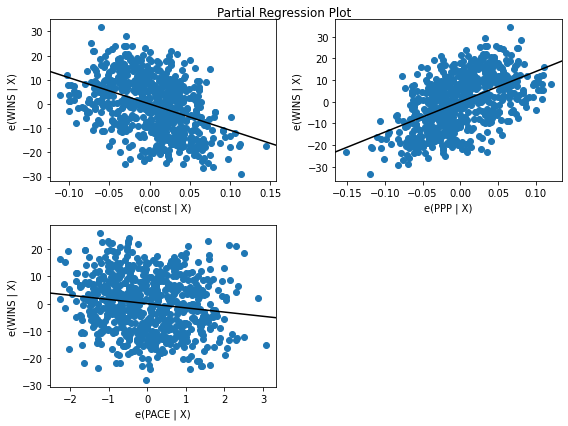

In [15]:
#Create partial regression plot
model = sm.OLS(df['WINS'], sm.add_constant(df[['PPP', 'PACE']])).fit()
fig = plt.figure(figsize=(8, 6))
plot_partregress_grid(model, fig=fig)
plt.show()